In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform
import tqdm

from pymutspec.annotation import mutations_summary, calculate_mutspec, lbl_id2lbl, lbl2lbl_id
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

## Load data

### Check invar sites intersection

In [2]:
r_nd1 = pd.concat([
    pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_nd1/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

r_cytb = pd.concat([
    pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/strsym.rate", comment="#", sep="\t"),
    pd.read_csv("../data/exposure/mammals_cytb/states/unrest.rate", comment="#", sep="\t"),
], ignore_index=True).groupby("Site").Cat.value_counts().unstack().fillna(0).astype(np.int8)

#### Different model assign different cats to same sites

In [4]:
r_nd1[r_nd1.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
48,0,0,0,0,1,1,1
222,0,0,0,0,1,1,1
229,0,0,0,1,1,1,0
234,0,0,0,0,1,1,1
246,0,0,0,0,1,1,1
265,0,0,0,1,1,1,0
369,0,0,0,0,1,1,1
396,0,0,0,0,1,1,1
405,0,0,0,0,1,1,1


In [9]:
r_cytb[r_cytb.max(axis=1) < 2]

Cat,0,1,2,3,4,5,6
Site,,,,,,,
72,0,0,0,0,1,1,1
240,0,0,0,0,1,1,1
426,0,0,0,0,1,1,1
477,0,0,0,0,1,1,1
712,0,0,0,1,1,1,0
1096,0,0,1,1,1,0,0


#### But invariable sites are same for each model

In [7]:
r_nd1[r_nd1[0] > 0][0].value_counts()

3    181
Name: 0, dtype: int64

In [8]:
r_cytb[r_cytb[0] > 0][0].value_counts()

3    267
Name: 0, dtype: int64

### Load rates and cats

In [2]:
dtypes_rate = {"Site": np.int16, "Cat": np.int8}

rate_nd1 = pd.read_csv("../data/exposure/mammals_nd1/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb = pd.read_csv("../data/exposure/mammals_cytb/states/gtr.rate", comment="#", sep="\t", dtype=dtypes_rate)
rate_cytb.head()

,Site,Rate,Cat,C_Rate
0,1,0.00187,0,0.00000
1,2,0.00003,0,0.00000
2,3,0.01569,1,0.01569
3,4,0.19571,2,0.12291
4,5,0.37341,3,0.37341


### Load observed mutations

In [3]:
dtypes = dict(
    Mut=str,
    Label=np.int8, 
    PosInGene=np.int16,
    ProbaMut=np.float32, 
    ProbaFull=np.float32,
    RefNode=str,
    AltNode=str,
)
usecols = list(dtypes.keys())
usecols_simple = [x for x in usecols if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_nd1/"
mut_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_nd1["MutBase"] = mut_nd1["Mut"].str.slice(2, 5).astype("category")


PATH_TO_DATA = "../data/exposure/mammals_cytb/"
mut_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/mutations.tsv"), dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/mutations.tsv"),  dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/mutations.tsv"),  dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/mutations.tsv"),   dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/mutations.tsv"),    dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/mutations.tsv"),dtype=dtypes, usecols=usecols_simple, sep='\t').assign(Aproach="RY10.12_simple"),

    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/mutations.tsv"),     dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/mutations.tsv"), dtype=dtypes, usecols=usecols, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(ProbaMut=1., ProbaRef=1., ProbaFull=1.))

mut_cytb["MutBase"] = mut_cytb["Mut"].str.slice(2, 5).astype("category")

mut_nd1 = mut_nd1[mut_nd1.RefNode != "ROOT"]
mut_cytb = mut_cytb[mut_cytb.RefNode != "ROOT"]

mut_nd1 = mut_nd1.merge(rate_nd1[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")
mut_cytb = mut_cytb.merge(rate_cytb[["Site", "Cat"]].rename(columns={"Site": "PosInGene"}), on="PosInGene")

In [4]:
mut_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2455647 entries, 0 to 2455646
Data columns (total 10 columns):
 #   Column     Dtype   
---  ------     -----   
 0   Mut        object  
 1   Label      int8    
 2   PosInGene  int16   
 3   RefNode    object  
 4   AltNode    object  
 5   Aproach    object  
 6   ProbaMut   float32 
 7   ProbaFull  float32 
 8   MutBase    category
 9   Cat        int8    
dtypes: category(1), float32(2), int16(1), int8(2), object(4)
memory usage: 124.1+ MB


### Load expected mutations freqs

In [5]:
dtypes_exp = dict(
    Mut=str,
    Label=str, 
    Pos=np.int16,
    Proba=np.float32, 
    Node=str,
)
usecols_exp = list(dtypes_exp.keys())
usecols_exp_simple = [x for x in usecols_exp if not x.startswith("Proba")]

PATH_TO_DATA = "../data/exposure/mammals_cytb/"
exp_cytb = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))


PATH_TO_DATA = "../data/exposure/mammals_nd1/"
exp_nd1 = pd.concat([
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="unrest_proba"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "unrest_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="unrest_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY6.8a_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY6.8a"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_simple/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="strsym_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_simple/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY8.8_simple"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "strsym_proba/expected_mutations.tsv"),  dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="strsym"),
    # pd.read_csv(os.path.join(PATH_TO_DATA, "RY8.8_proba/expected_mutations.tsv"),   dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY8.8"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_simple/expected_mutations.tsv"),    dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="gtr_simple"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_simple/expected_mutations.tsv"),dtype=dtypes_exp, usecols=usecols_exp_simple, sep='\t').assign(Aproach="RY10.12_simple"),
    
    pd.read_csv(os.path.join(PATH_TO_DATA, "gtr_proba/expected_mutations.tsv"),     dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="gtr"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "RY10.12_proba/expected_mutations.tsv"), dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="RY10.12"),
    pd.read_csv(os.path.join(PATH_TO_DATA, "pastml/expected_mutations.tsv"),        dtype=dtypes_exp, usecols=usecols_exp, sep='\t').assign(Aproach="pastml"),
], ignore_index=True).fillna(value=dict(Proba=1.))

exp_nd1 = exp_nd1[(exp_nd1.Mut.isin(possible_sbs192)) & (exp_nd1.Node != "ROOT")]
exp_cytb = exp_cytb[(exp_cytb.Mut.isin(possible_sbs192)) & (exp_cytb.Node != "ROOT")]

exp_nd1["Cat"] = exp_nd1.Pos.map(rate_nd1.set_index("Site").Cat.to_dict()).astype(np.int8)
exp_cytb["Cat"] = exp_cytb.Pos.map(rate_cytb.set_index("Site").Cat.to_dict()).astype(np.int8)

In [6]:
exp_cytb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47270795 entries, 0 to 51050686
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Pos      int16  
 1   Mut      object 
 2   Label    object 
 3   Node     object 
 4   Aproach  object 
 5   Proba    float32
 6   Cat      int8   
dtypes: float32(1), int16(1), int8(1), object(4)
memory usage: 2.1+ GB


### How many mutations with diffrent types observed?

In [9]:
mutations_summary(mut_cytb, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Aproach,,,,,,
RY10.12,9118,122415,64536,25,22,0
RY10.12_simple,10285,82701,41292,4,3,0
RY8.8,9113,122409,64561,25,22,0
RY8.8_simple,10306,82727,41314,4,3,0
gtr,9141,122471,66058,25,22,0
gtr_simple,10356,82535,41547,4,3,0
pastml,10147,135584,62552,39,37,0
strsym,9927,86666,43811,14,13,0
strsym_simple,10063,80472,40524,2,2,0


In [10]:
mutations_summary(mut_cytb[mut_cytb.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,6208,60464,29352,1,1
RY10.12_simple,10285,82701,41292,4,3
RY8.8,6206,60425,29328,1,1
RY8.8_simple,10306,82727,41314,4,3
gtr,6125,59748,28901,1,1
gtr_simple,10356,82535,41547,4,3
pastml,6458,65373,31349,1,1
strsym,7753,66807,32628,1,1
strsym_simple,10063,80472,40524,2,2


In [11]:
mutations_summary(mut_nd1, "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,7245,101214,56852,5,3
RY10.12_simple,8360,68091,35728,6,3
RY8.8,7245,101209,56850,5,3
RY8.8_simple,8359,68081,35718,6,3
gtr,7265,100689,57338,5,3
gtr_simple,8347,67617,35585,7,4
pastml,8074,109884,53672,6,3
strsym,7940,72442,37375,1,2
strsym_simple,8101,66189,34596,0,2


In [12]:
mutations_summary(mut_nd1[mut_nd1.ProbaFull > 0.3], "Aproach", "ProbaFull").astype(int)

,non-syn,syn,syn4f,Stop loss,Stop gain
Aproach,,,,,
RY10.12,4783,49864,25566,1,1
RY10.12_simple,8360,68091,35728,6,3
RY8.8,4783,49863,25564,1,1
RY8.8_simple,8359,68081,35718,6,3
gtr,4742,49404,25247,0,1
gtr_simple,8347,67617,35585,7,4
pastml,5084,53083,26767,1,1
strsym,6112,54923,28244,0,1
strsym_simple,8101,66189,34596,0,2


**Probability distribution of mutations**

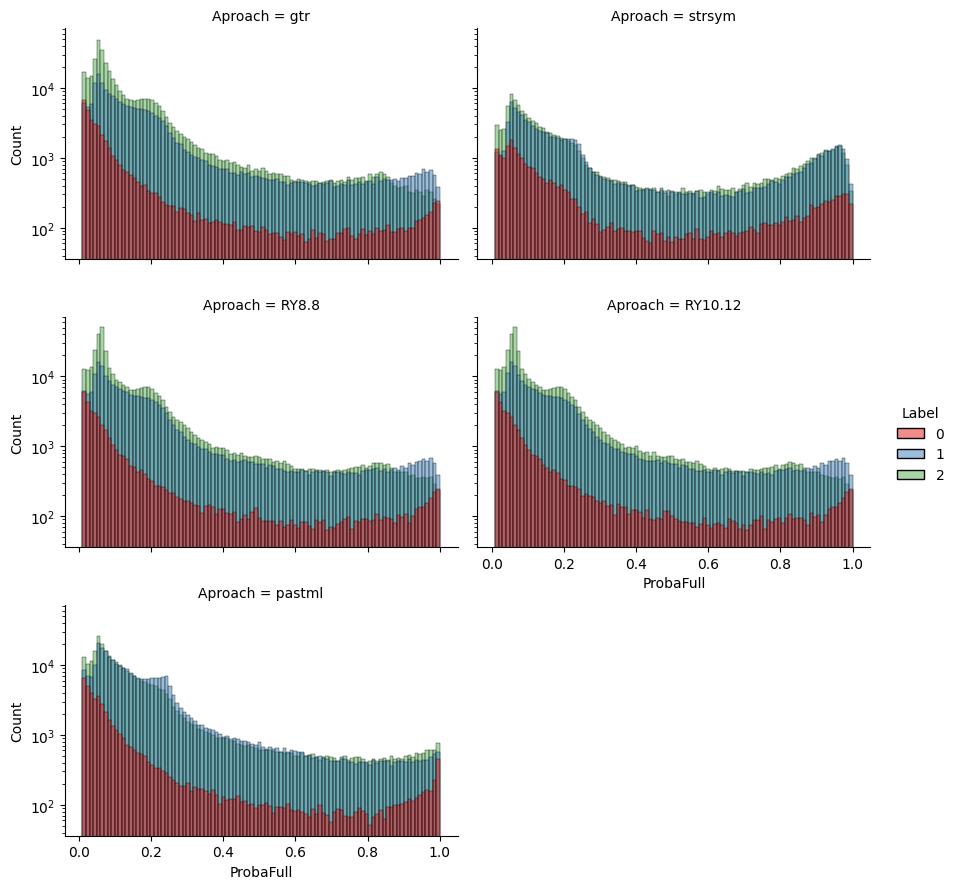

In [13]:
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (~mut_nd1.Aproach.str.contains("simple")) & (mut_nd1.ProbaFull > 0.01)], 
    x="ProbaFull", hue="Label", col="Aproach", col_wrap=2,
    log_scale=[False, True], bins=100, palette="Set1", aspect=1.5, height=3,
)
plt.show()

**Number of mutations in tree edges**

In [18]:
sns.kdeplot?

Signature:
sns.kdeplot(
    x=None,
    *,
    y=None,
    shade=None,
    vertical=False,
    kernel=None,
    bw=None,
    gridsize=200,
    cut=3,
    clip=None,
    legend=True,
    cumulative=False,
    shade_lowest=None,
    cbar=False,
    cbar_ax=None,
    cbar_kws=None,
    ax=None,
    weights=None,
    hue=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    multiple='layer',
    common_norm=True,
    common_grid=False,
    levels=10,
    thresh=0.05,
    bw_method='scott',
    bw_adjust=1,
    log_scale=None,
    color=None,
    fill=None,
    data=None,
    data2=None,
    warn_singular=True,
    **kwargs,
)
Docstring:
Plot univariate or bivariate distributions using kernel density estimation.

A kernel density estimate (KDE) plot is a method for visualizing the
distribution of observations in a dataset, analagous to a histogram. KDE
represents the data using a continuous probability density curve in one or
more dimensions.

The approach is explained further 

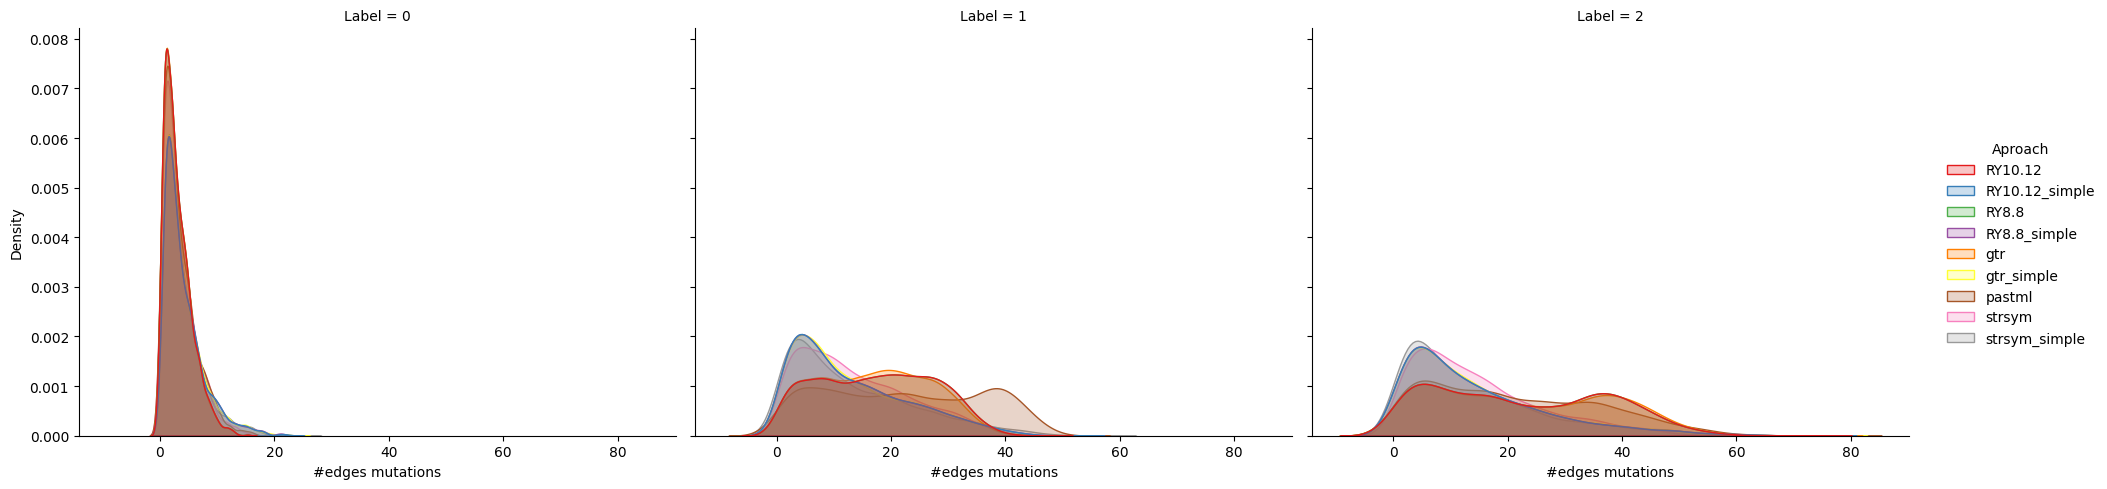

In [21]:
sns.displot(
    data=mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", kind="kde", fill=True,
).set_axis_labels("#edges mutations");
plt.show()

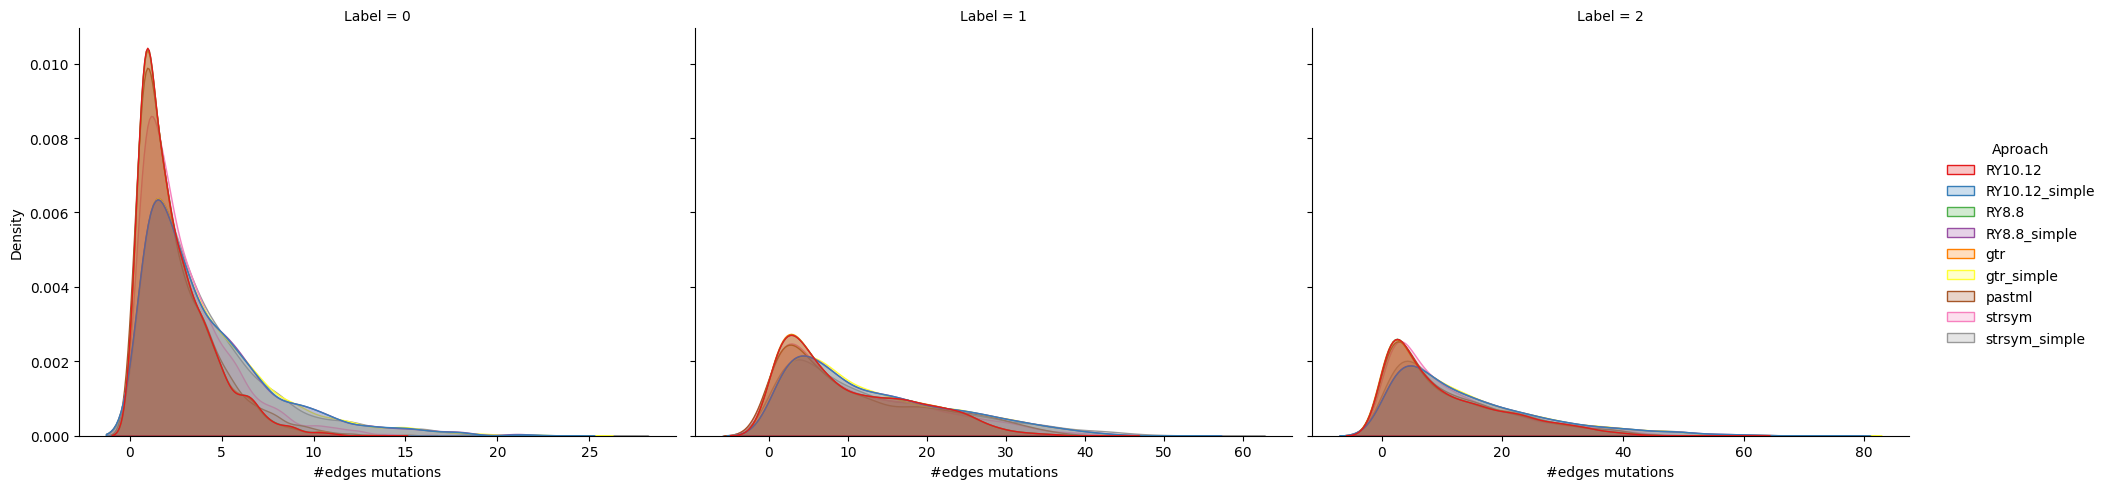

In [22]:
# after filtration (P > 0.3)
sns.displot(
    data=mut_nd1[(mut_nd1.Label >= 0) & (mut_nd1.ProbaFull > 0.3)].groupby(["Aproach", "Label", "AltNode"]).ProbaFull.sum().reset_index(), 
    x="ProbaFull", col="Label", hue="Aproach", aspect=1.3, palette="Set1", facet_kws=dict(sharex=False), kind="kde", fill=True,
).set_axis_labels("#edges mutations");
plt.show()

## QC of rate and probability

In [19]:
def complete_sbs192_columns(df: pd.DataFrame):
    df = df.copy()
    if len(df.columns) != 192:
        for sbs192 in set(possible_sbs192).difference(df.columns.values):
            df[sbs192] = 0.
    df = df[possible_sbs192]
    return df


def jackknife_spectra_sampling(obs: pd.DataFrame, exp: pd.DataFrame, frac=0.5, n=1000):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        altnodes  = obs.index.get_level_values(1).values
        obs_edges = obs
        freqs_nodes = exp
        obs_edges.index = obs_edges.index.reorder_levels(order=["AltNode", "RefNode"])
        freqs_nodes.index.name = "RefNode"
    else:
        altnodes = obs.AltNode.unique()
        obs_edges = obs.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.rename(columns={"Node": "RefNode"}).groupby(["RefNode", "Mut"]).Proba.sum().unstack()
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    edges_sample_size = int(len(altnodes) * frac)
    spectra = []
    for _ in range(n):
        altnodes_sample = np.random.choice(altnodes, edges_sample_size, False)
        obs_sample = obs_edges.loc[altnodes_sample].reset_index(0, drop=True)
        exp_sample = freqs_nodes.loc[obs_sample.index]
        
        obs_sample_cnt = obs_sample.sum()
        exp_sample_cnt = exp_sample.sum()

        assert (obs_sample_cnt.index == exp_sample_cnt.index).all()

        sample_spectra = obs_sample_cnt / exp_sample_cnt
        spectra.append(sample_spectra)

    return pd.DataFrame(spectra).fillna(0.)


def collapse_sbs192(df: pd.DataFrame, to=12):
    assert (df.columns == possible_sbs192).all()
    df = df.copy()
    if to == 12:
        for sbs192 in possible_sbs192:
            sbs12 = sbs192[2:5]
            if sbs12 in df.columns.values:
                df[sbs12] += df[sbs192]
            else:
                df[sbs12] = df[sbs192]

        return df[possible_sbs12]
    else:
        raise NotImplementedError()


def calc_edgewise_spectra(obs: pd.DataFrame, exp: pd.DataFrame, nmtypes_cutoff=16, collapse_to_12=False):
    if len(obs.columns) == 192 and (obs.columns == possible_sbs192).all() and (exp.columns == possible_sbs192).all():
        assert obs.index.names == ["RefNode", "AltNode"]
        assert exp.index.names == ["Node"]
        obs_edges = obs
        freqs_nodes = exp
        freqs_nodes.index.name = "RefNode"
    else:
        obs_edges = obs.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
        obs_edges = complete_sbs192_columns(obs_edges)
        freqs_nodes = exp.groupby(["Node", "Mut"]).Proba.sum().unstack()
        freqs_nodes.index.name = "RefNode"
        freqs_nodes = complete_sbs192_columns(freqs_nodes)

    if not collapse_to_12:
        obs_edges = obs_edges[(obs_edges > 0).sum(axis=1) >= nmtypes_cutoff]
    
    edges_df = obs_edges.index.to_frame(False)

    freqs_edges = edges_df.merge(freqs_nodes, on="RefNode")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (obs_edges.columns == freqs_edges.columns).all()
    assert (obs_edges.index == freqs_edges.index).all()

    if collapse_to_12:
        obs_edges   = collapse_sbs192(obs_edges, to=12)
        freqs_edges = collapse_sbs192(freqs_edges, to=12)

    spectra = (obs_edges / freqs_edges).replace(np.inf, 0.).fillna(0.)
    spectra = (spectra.T / spectra.T.sum(axis=0)).T

    assert not (spectra == np.inf).any().any()
    assert not (spectra.isna()).any().any()

    return spectra


def assign_cat(p: float, interval=0.1):
    if interval < 0.01:
        raise NotImplementedError
    
    left = p // interval / (1 / interval)
    right = left + interval
    if interval >= 0.1:
        return f"{left:.1f}_{right:.1f}"
    else:
        return f"{left:.2f}_{right:.2f}"


def get_cossim(a: pd.DataFrame, b: pd.DataFrame):
    assert (a.columns == b.columns).all()
    
    common_index = a.index.intersection(b.index)
    if len(common_index) == 0:
        return pd.Series()
    
    a = a.loc[common_index]
    b = b.loc[common_index]

    assert (a.index == b.index).all()
    dotprod = (a * b).sum(axis=1)
    a_norm = (a ** 2).sum(axis=1) ** 0.5
    b_norm = (b ** 2).sum(axis=1) ** 0.5
    cossim = dotprod / (a_norm * b_norm)
    return cossim

### Choose low-rate category cutoff

In [8]:
lbl = "syn"
pcutoff = 0.3

simple_approaches = [x for x in mut_cytb.Aproach.unique() if "simple" in x]

obs_cytb_syn = mut_cytb[(~mut_cytb.Aproach.isin(simple_approaches)) & (mut_cytb.Label >= lbl2lbl_id(lbl)) & (mut_cytb.ProbaFull >= pcutoff)]
obs_nd1_syn  = mut_nd1[(~mut_nd1.Aproach.isin(simple_approaches)) & (mut_nd1.Label   >= lbl2lbl_id(lbl)) & (mut_nd1.ProbaFull  >= pcutoff)]
exp_cytb_syn = exp_cytb[(~exp_cytb.Aproach.isin(simple_approaches)) & (exp_cytb.Label == lbl) & (exp_cytb.Proba >= pcutoff)]
exp_nd1_syn  = exp_nd1[(~exp_nd1.Aproach.isin(simple_approaches)) & (exp_nd1.Label   == lbl) & (exp_nd1.Proba  >= pcutoff)]

obs_cytb_syn.loc[obs_cytb_syn.Cat < 3, "Cat"] = 3
obs_nd1_syn.loc[obs_nd1_syn.Cat < 3,   "Cat"] = 3
exp_cytb_syn.loc[exp_cytb_syn.Cat < 3, "Cat"] = 3
exp_nd1_syn.loc[exp_nd1_syn.Cat < 3,   "Cat"] = 3

In [22]:
data = []
for gene, mut, exp in zip(["cytb", "nd1"], [obs_cytb_syn, obs_nd1_syn], [exp_cytb_syn, exp_nd1_syn]):
    print(gene)

    for (appr, rcat), obs_cur in mut.groupby(["Aproach", "Cat"]):    
        if obs_cur.ProbaFull.sum() < 200 or obs_cur.Mut.nunique() < 20:
            print(appr, rcat, "- pass")
            continue

        exp_cur = exp[(exp.Aproach == appr) & (exp.Cat == rcat)]
        
        print(obs_cur.AltNode.nunique())
        if obs_cur.AltNode.nunique() == 1960:
            break

        spectra = jackknife_spectra_sampling(obs_cur, exp_cur, n=100)
        spectra = spectra.assign(Gene=gene, Aproach=appr, RateCat=rcat).set_index(["Gene", "Aproach", "RateCat"])
        data.append(spectra)
    break

spectra_cats_to_compare = pd.concat(data)

cytb
RY10.12 3 - pass
1974
2472
2320
RY8.8 3 - pass
1975
2470
2319
gtr 3 - pass
1960


In [50]:
# _sr = spectra_cats_to_compare.mean(level=[0,1,2])
# _srd = pd.DataFrame(1 - squareform(pdist(_sr, "cosine")), index=_sr.index, columns=_sr.index)

_srd = a = pd.DataFrame(1 - squareform(pdist(spectra_cats_to_compare, "cosine")), index=spectra_cats_to_compare.index, columns=spectra_cats_to_compare.index) 

data = []
for g in _srd.index.levels[0]:
    for appr in _srd.index.levels[1]:
        a = _srd.loc[(g, appr), (g, appr)]
        a.index.rename("RateCat1", inplace=True)
        a.columns.rename("RateCat2", inplace=True)
        a = a.stack().mean(level=[0,1]).rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,RateCat1,RateCat2,Sim,Gene,Approach
0,4,4,0.879253,cytb,RY10.12
1,4,5,0.782485,cytb,RY10.12
2,4,6,0.603533,cytb,RY10.12
3,5,4,0.782485,cytb,RY10.12
4,5,5,0.988028,cytb,RY10.12


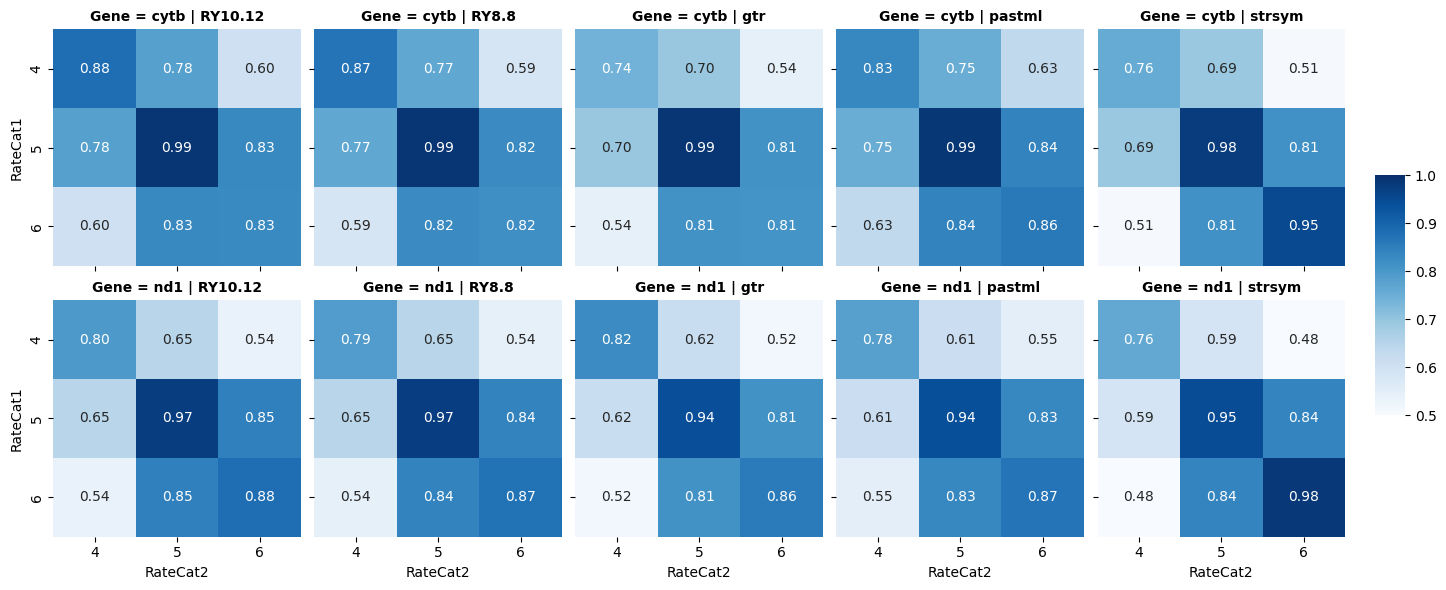

In [51]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="RateCat1", columns='RateCat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0.5, vmax=1, annot=True, fmt=".2f")  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()

In [ ]:
# plt.figure(figsize=(20, 10))
# plt.subplot(121)
# plt.title("Cytb")
# sns.heatmap(_srd.loc["cytb", "cytb"], cbar=False, cmap="coolwarm", annot=True, annot_kws={"size": 10}, fmt=".2f", vmin=0.5, vmax=1.0)

# plt.subplot(122)
# plt.title("ND1")
# sns.heatmap(_srd.loc["nd1", "nd1"], cbar=False, cmap="coolwarm", annot=True, annot_kws={"size": 10}, fmt=".2f", vmin=0.5, vmax=1.0)
# plt.show()

**Conclusion: positions of 4 rate-category too different from 6 and even 5 cats**

### Choose low-probability cutoff

On high-rate spectra

In [83]:
lbl = "syn"
low_cat = 4
pcutoff = 0.3

obs_cytb_syn = mut_cytb[(mut_cytb.Label >= lbl2lbl_id(lbl)) & (mut_cytb.Cat > low_cat)]
obs_nd1_syn  = mut_nd1[(mut_nd1.Label   >= lbl2lbl_id(lbl)) & (mut_nd1.Cat  > low_cat)]
exp_cytb_syn = exp_cytb[(exp_cytb.Label == lbl) & (exp_cytb.Cat > low_cat) & (exp_cytb.Proba > pcutoff)]
exp_nd1_syn  = exp_nd1[(exp_nd1.Label   == lbl) & (exp_nd1.Cat  > low_cat) & (exp_nd1.Proba  > pcutoff)]

obs_cytb_syn["ProbaCat"] = obs_cytb_syn["ProbaFull"].apply(assign_cat)
obs_nd1_syn ["ProbaCat"] = obs_nd1_syn ["ProbaFull"].apply(assign_cat)

In [96]:
data = []
for gene, mut, exp in zip(["cytb", "nd1"], [obs_cytb_syn, obs_nd1_syn], [exp_cytb_syn, exp_nd1_syn]):
    print(gene)

    for (appr, pcat), obs_cur in mut.groupby(["Aproach", "ProbaCat"]):       
        if obs_cur.ProbaFull.sum() < 200 or obs_cur.Mut.nunique() < 20:
            print(appr, pcat, "- pass")
            continue

        exp_cur = exp[(exp.Aproach == appr)]

        # spectra = jackknife_spectra_sampling(obs_cur, exp_cur, n=100)
        spectra = calc_edgewise_spectra(obs_cur, exp_cur, )
        spectra = spectra.assign(Gene=gene, Aproach=appr, ProbaCat=pcat).set_index(["Gene", "Aproach", "ProbaCat"], append=True)
        data.append(spectra)

spectra_cats_to_compare = pd.concat(data)
spectra_cats_to_compare.index = spectra_cats_to_compare.index.reorder_levels(order=['Gene', 'Aproach', 'ProbaCat', 'RefNode', 'AltNode'])

cytb
nd1


In [131]:
## jackknife sampling comparing

# _srd = a = pd.DataFrame(1 - squareform(pdist(spectra_cats_to_compare, "cosine")), index=spectra_cats_to_compare.index, columns=spectra_cats_to_compare.index) 

# data = []
# for g in _srd.index.levels[0]:
#     for appr in _srd.index.levels[1]:
#         if "simple" in appr:
#             continue
#         a = _srd.loc[(g, appr), (g, appr)]
#         a.index.rename("ProbaCat1", inplace=True)
#         a.columns.rename("ProbaCat2", inplace=True)
#         a = a.stack().mean(level=[0,1]).rename("Sim").reset_index()
#         a["Gene"] = g
#         a["Approach"] = appr
#         data.append(a)

# sim_df_mean = pd.concat(data)
# sim_df_mean.head()


## edgewise comparing

data = []
for g in spectra_cats_to_compare.index.levels[0]:
    for appr in spectra_cats_to_compare.index.levels[1]:
        if "simple" in appr:
            continue
        for pc1, pc2 in combinations(spectra_cats_to_compare.index.levels[2], 2):
            edges1 = spectra_cats_to_compare.loc[(g, appr, pc1)]
            edges2 = spectra_cats_to_compare.loc[(g, appr, pc2)]
            sim = get_cossim(edges1, edges2)
            ava_sim = sim.mean()
            data.append((g, appr, pc1, pc2, ava_sim))

sim_df_mean = pd.DataFrame(data, columns=["Gene", "Approach", "ProbaCat1", "ProbaCat2", "CosSim"])
sim_df_mean.head()

,Gene,Approach,ProbaCat1,ProbaCat2,CosSim
0,cytb,RY10.12,0.0_0.1,0.1_0.2,0.434806
1,cytb,RY10.12,0.0_0.1,0.2_0.3,0.367499
2,cytb,RY10.12,0.0_0.1,0.3_0.4,0.257536
3,cytb,RY10.12,0.0_0.1,0.4_0.5,0.178994
4,cytb,RY10.12,0.0_0.1,0.5_0.6,0.135115


In [135]:
sim_df_mean[(sim_df_mean.Gene == "cytb") & (sim_df_mean.Approach == "pastml")].pivot(index="ProbaCat1", columns='ProbaCat2', values='CosSim').T

ProbaCat1,0.0_0.1,0.1_0.2,0.2_0.3,0.3_0.4,0.4_0.5,0.5_0.6,0.6_0.7,0.7_0.8,0.8_0.9
ProbaCat2,,,,,,,,,
0.1_0.2,0.505667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.2_0.3,0.418734,0.458655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.3_0.4,0.283689,0.316663,0.287093,NaN,NaN,NaN,NaN,NaN,NaN
0.4_0.5,0.176413,0.221860,0.222245,0.180097,NaN,NaN,NaN,NaN,NaN
0.5_0.6,0.135287,0.145164,0.137916,0.132836,0.183419,NaN,NaN,NaN,NaN
0.6_0.7,0.108800,0.144960,0.112761,0.092829,0.149947,0.189930,NaN,NaN,NaN
0.7_0.8,0.083970,0.059833,0.072142,0.078856,0.090658,0.163653,0.160210,NaN,NaN
0.8_0.9,0.062395,0.098883,0.072193,0.079116,0.121180,0.134195,0.129040,0.28816,NaN
0.9_1.0,0.095695,0.083492,0.065232,0.039243,0.032022,0.054956,0.247053,NaN,0.107642


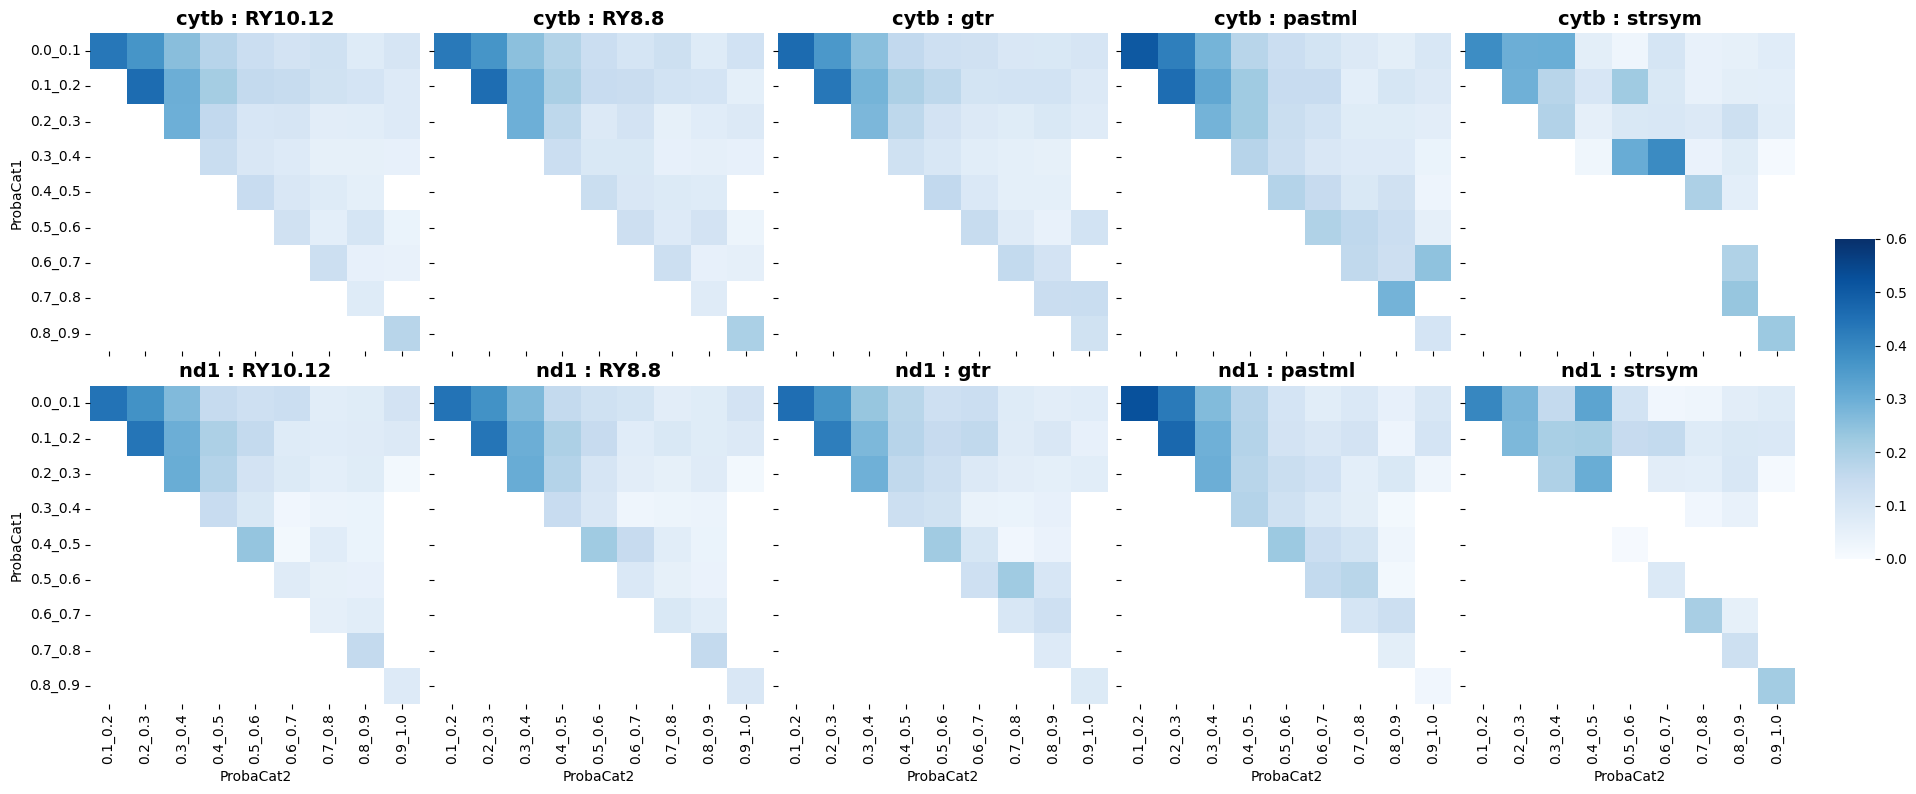

In [138]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="ProbaCat1", columns='ProbaCat2', values='CosSim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=4, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0.0, vmax=0.6)  # <-- Specify the colorbar axes and limits

g.set_titles(template="{row_name} : {col_name}", fontweight='bold', size=14)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()

**Conclusion: [0, 0.2) and MAYBE [0.2, 0.3) are different categories**

### Calculate perfect freqs

In [8]:
LOW_CAT = 4
pcutoff = 0.3

freqs_nd1_high_rate  = exp_nd1[(exp_nd1.Cat   > LOW_CAT) & (exp_nd1.Proba  > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
freqs_cytb_high_rate = exp_cytb[(exp_cytb.Cat > LOW_CAT) & (exp_cytb.Proba > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

assert freqs_nd1_high_rate.shape[1] == 192
assert freqs_cytb_high_rate.shape[1] == 192

freqs_nd1_high_rate  = freqs_nd1_high_rate.reset_index()
freqs_cytb_high_rate = freqs_cytb_high_rate.reset_index()


# freqs_nd1_low_rate = exp_nd1[(exp_nd1.Cat <= LOW_CAT) & (exp_nd1.Proba > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)
# freqs_cytb_low_rate = exp_cytb[(exp_cytb.Cat <= LOW_CAT) & (exp_cytb.Proba > pcutoff)].groupby(["Aproach", "Node", "Label", "Mut"]).Proba.sum().unstack().fillna(0.)

# assert freqs_nd1_low_rate.shape[1] == 192
# assert freqs_cytb_low_rate.shape[1] == 192

# freqs_nd1_low_rate = freqs_nd1_low_rate.reset_index()
# freqs_cytb_low_rate = freqs_cytb_low_rate.reset_index()

### Different approaches comparing

In [20]:
obs_cytb = mut_cytb[(mut_cytb.ProbaFull > pcutoff) & (mut_cytb.Cat > LOW_CAT)]
obs_nd1  = mut_nd1[ (mut_nd1.ProbaFull > pcutoff)  & (mut_nd1.Cat > LOW_CAT)]

data = []
for gene, obs, exp in zip(["cytb", "nd1"], [obs_cytb, obs_nd1], [freqs_cytb_high_rate, freqs_nd1_high_rate]):
    for lbl in ["all", "syn", "syn_c", "syn4f"]:
        exp_gene_lbl = exp[exp.Label == lbl].set_index(["Aproach", "Node"])[possible_sbs192]
        if lbl == "syn_c":
            lbl = "syn"
        elif lbl == "syn4f":
            lbl = "ff"

        obs_gene_lbl = obs[(obs.Label >= lbl2lbl_id(lbl))].groupby(["Aproach", "RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack().fillna(0.)
        obs_gene_lbl = complete_sbs192_columns(obs_gene_lbl)


        assert (obs_gene_lbl.columns == exp_gene_lbl.columns).all()
        
        for appr in obs_gene_lbl.index.get_level_values(0).unique():
            # spectra = jackknife_spectra_sampling(obs_gene_lbl.loc[appr], exp_gene_lbl.loc[appr], n=100)
            spectra = calc_edgewise_spectra(obs_gene_lbl.loc[appr], exp_gene_lbl.loc[appr])
            spectra = spectra.assign(Gene=gene, Aproach=appr, Label=lbl).set_index(["Gene", "Label", "Aproach"], append=True)
            data.append(spectra)

    print(gene)

gene_appr_spectra = pd.concat(data)
gene_appr_spectra.index = gene_appr_spectra.index.reorder_levels(order=['Gene', 'Label', 'Aproach', 'RefNode', 'AltNode'])
gene_appr_spectra.head()

cytb
nd1


Mut                                   A[A>C]A  A[A>C]C  A[A>C]G   A[A>C]T  \
Gene Label Aproach RefNode  AltNode                                         
cytb all   RY10.12 Node1    Node1320      0.0      0.0      0.0  0.000000   
                            RN_1          0.0      0.0      0.0  0.000000   
                   Node100  RN_159        0.0      0.0      0.0  0.000000   
                            RN_160        0.0      0.0      0.0  0.010351   
                   Node1000 RN_719        0.0      0.0      0.0  0.000000   

Mut                                   C[A>C]A  C[A>C]C  C[A>C]G   C[A>C]T  \
Gene Label Aproach RefNode  AltNode                                         
cytb all   RY10.12 Node1    Node1320      0.0  0.00000      0.0  0.002839   
                            RN_1          0.0  0.00000      0.0  0.000000   
                   Node100  RN_159        0.0  0.00000      0.0  0.000000   
                            RN_160        0.0  0.00000      0.0  0.011382   
                   Node1000 RN_719        0.0  0.01504      0.0  0.000000   

Mut                                   G[A>C]A   G[A>C]C  ...  C[T>G]G  \
Gene Label Aproach RefNode  AltNode                      ...            
cytb all   RY10.12 Node1    Node1320      0.0  0.000000  ...      0.0   
                            RN_1          0.0  0.000000  ...      0.0   
                   Node100  RN_159        0.0  0.000000  ...      0.0   
                            RN_160        0.0  0.025533  ...      0.0   
                   Node1000 RN_719        0.0  0.000000  ...      0.0   

Mut                                   C[T>G]T  G[T>G]A  G[T>G]C  G[T>G]G  \
Gene Label Aproach RefNode  AltNode                                        
cytb all   RY10.12 Node1    Node1320      0.0      0.0      0.0      0.0   
                            RN_1          0.0      0.0      0.0      0.0   
                   Node100  RN_159        0.0      0.0      0.0      0.0   
                            RN_160        0.0      0.0      0.0      0.0   
                   Node1000 RN_719        0.0      0.0      0.0      0.0   

Mut                                   G[T>G]T  T[T>G]A   T[T>G]C  T[T>G]G  \
Gene Label Aproach RefNode  AltNode                                         
cytb all   RY10.12 Node1    Node1320      0.0      0.0  0.000000      0.0   
                            RN_1          0.0      0.0  0.000000      0.0   
                   Node100  RN_159        0.0      0.0  0.002442      0.0   
                            RN_160        0.0      0.0  0.000000      0.0   
                   Node1000 RN_719        0.0      0.0  0.000000      0.0   

Mut                                   T[T>G]T  
Gene Label Aproach RefNode  AltNode            
cytb all   RY10.12 Node1    Node1320      0.0  
                            RN_1          0.0  
                   Node100  RN_159        0.0  
                            RN_160        0.0  
                   Node1000 RN_719        0.0  

[5 rows x 192 columns]

In [22]:
apches = ['pastml', 'RY10.12', 'gtr', 'RY10.12_simple', 'gtr_simple']

data = []
for gene in gene_appr_spectra.index.get_level_values(0).unique():
    for _lbl in gene_appr_spectra.index.get_level_values(1).unique():

        for a1, a2 in combinations(apches, 2):
            # sims = 1 - cdist(gene_appr_spectra.loc[(gene, _lbl, a1)], gene_appr_spectra.loc[(gene, _lbl, a2)], "cosine")
            sims = get_cossim(gene_appr_spectra.loc[(gene, _lbl, a1)], gene_appr_spectra.loc[(gene, _lbl, a2)])
            # ava_sim = sims.mean()
            data.append((gene, _lbl, a1, a2, sims.values))

sim_df_mean = pd.DataFrame(data, columns=["Gene", "Label", "Approach1", "Approach2", "Sim"]).explode("Sim", True)

In [23]:
sim_df_mean

,Gene,Label,Approach1,Approach2,Sim
0,cytb,all,pastml,RY10.12,0.846239
1,cytb,all,pastml,RY10.12,0.777158
2,cytb,all,pastml,RY10.12,0.909009
3,cytb,all,pastml,RY10.12,0.771706
4,cytb,all,pastml,RY10.12,0.987553
...,...,...,...,...,...
93824,nd1,ff,RY10.12_simple,gtr_simple,0.745168
93825,nd1,ff,RY10.12_simple,gtr_simple,0.972382
93826,nd1,ff,RY10.12_simple,gtr_simple,1.0
93827,nd1,ff,RY10.12_simple,gtr_simple,0.994677


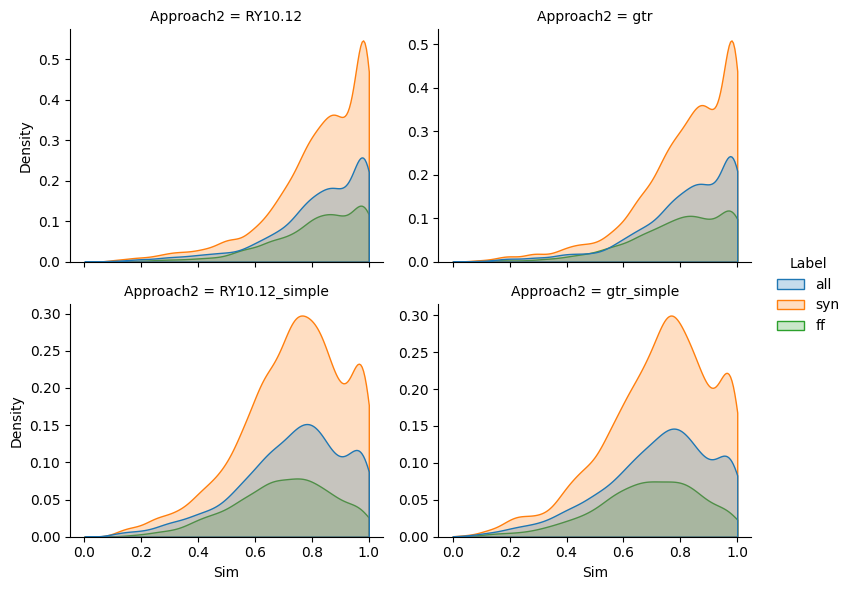

In [24]:
sns.displot(
    data=sim_df_mean[sim_df_mean.Approach1 == "pastml"],
    x="Sim", hue="Label", col="Approach2", col_wrap=2,
    kind="kde", fill=True, clip=(0, 1), height=3, aspect=1.3,
    facet_kws=dict(sharex=True, sharey=False), 
)
plt.show()

## Categorizing mutations

In [26]:
mut_cytb[mut_cytb.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat                     1     2     3      4      5      6
Aproach        Label                                      
RY10.12        0      546  1523  2667   2333   1659    387
               1       10    36   564   7010  44884   5373
               2        0     0     0    311  17745  46478
RY10.12_simple 0      636  1832  3036   2568   1809    404
               1       11    36   606   6573  31201   2982
               2        0     0     1    279  13760  27252
RY8.8          0      546  1523  2665   2331   1658    386
               1       10    35   564   7003  44860   5374
               2        0     0     0    311  17734  46514
RY8.8_simple   0      638  1836  3036   2569   1817    410
               1       11    37   606   6569  31204   2986
               2        0     0     1    282  13751  27280
gtr            0      547  1518  2628   2383   1694    369
               1       10    32   562   6920  43617   5270
               2        0     0     0    322  18834  46901
gtr_simple     0      644  1832  3010   2623   1853    394
               1       11    37   602   6527  30820   2991
               2        0     0     1    280  14118  27148
pastml         0      693  1795  2970   2476   1757    454
               1       14    35   738  10765  56569   4907
               2        0     0     1    361  20119  42069
strsym         0      609  1756  3041   2412   1746    359
               1       12    34   593   6693  32441   3079
               2        0     0     0    280  14463  29066
strsym_simple  0      661  1838  3037   2377   1778    372
               1       14    35   605   6545  30050   2699
               2        0     0     1    280  13567  26676

In [27]:
mut_nd1[mut_nd1.Label >= 0].groupby(["Aproach", "Label", "Cat"]).ProbaFull.sum().unstack().fillna(0).astype(int)

Cat                     1     2     3     4      5      6
Aproach        Label                                     
RY10.12        0      338   936  2000  1909   1583    476
               1        1    43   125  3266  33421   7501
               2        0     0     0   117   8138  48596
RY10.12_simple 0      405  1148  2341  2218   1738    510
               1        1    41   128  3252  24705   4236
               2        0     0     0   112   6101  29515
RY8.8          0      338   935  2001  1909   1583    476
               1        1    43   125  3265  33419   7502
               2        0     0     0   117   8136  48597
RY8.8_simple   0      404  1148  2341  2221   1737    508
               1        1    41   128  3255  24704   4234
               2        0     0     0   112   6099  29507
gtr            0      338   930  1992  1935   1610    458
               1        1    41   125  3246  32626   7309
               2        0     0     0   118   8360  48859
gtr_simple     0      409  1129  2346  2246   1719    498
               1        1    41   131  3230  24446   4183
               2        0     0     0   111   6125  29349
pastml         0      429  1167  2112  2089   1745    529
               1        1    45   152  4531  44218   7261
               2        0     0     0   138   9168  44366
strsym         0      389  1094  2254  2095   1673    431
               1        1    41   129  3144  27425   4323
               2        0     0     0   109   6242  31022
strsym_simple  0      426  1167  2253  2107   1689    459
               1        3    41   131  3180  24384   3854
               2        0     0     0   114   5919  28563

In [143]:
def calc_tree_mutspec2(mut:pd.DataFrame, freqs, lbl="syn", pmin=0.0, pmax=1.0, collapse=False):
    mut = mut[
        (mut.Label >= lbl2lbl_id(lbl)) & 
        (mut.ProbaFull.between(pmin, pmax, "right"))
    ]
    # print("#mutations:", mut.ProbaFull.sum())
    if mut.ProbaFull.sum() < 100:
        return None
    mut = mut.groupby(["RefNode", "AltNode", "Mut"]).ProbaFull.sum().unstack()
    assert len(mut) > 0
            
    mut = complete_sbs192_columns(mut)
    
    freqs = freqs[freqs.Label == lbl]
    edges_df = mut.index.to_frame(False)

    freqs = edges_df.merge(freqs, left_on="RefNode", right_on="Node")\
        .set_index(["RefNode", "AltNode"])[possible_sbs192]
    
    assert (mut.columns == freqs.columns).all()
    assert (mut.index == freqs.index).all()

    spectra = (mut / freqs).fillna(0.)
    spectra = (spectra.T / spectra.T.sum(axis=0)).T

    return spectra


In [9]:
# space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]
space = [0.00, 0.30, 1.00]

### SYN (phylo-like adjusting)

In [32]:
lbl = "syn"

ms_cat_cytb = []
ms_cat_nd1 = []

for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    mapr_cytb = mut_cytb[(mut_cytb.Aproach == apr)]
    mapr_nd1  = mut_nd1[(mut_nd1.Aproach == apr)]

    for p1, p2 in zip(space[:-1], space[1:]):
        # CYTB
        m = mapr_cytb[(mapr_cytb.Cat <= LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, cytb low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec2(
            m, 
            freqs_cytb_low_rate[freqs_cytb_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_low_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_low_rate["Aproach"] = apr
            ms_low_rate["Rate"] = "low"
            ms_cat_cytb.append(ms_low_rate)

        m = mapr_cytb[(mapr_cytb.Cat > LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, cytb high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec2(
            m, 
            freqs_cytb_high_rate[freqs_cytb_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_high_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_high_rate["Aproach"] = apr
            ms_high_rate["Rate"] = "high"
            ms_cat_cytb.append(ms_high_rate)

        # ND1
        m = mapr_nd1[(mapr_nd1.Cat <= LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, nd1 low - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_low_rate = calc_tree_mutspec2(
            m, 
            freqs_nd1_low_rate[freqs_nd1_low_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_low_rate is not None:
            ms_low_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_low_rate["Aproach"] = apr
            ms_low_rate["Rate"] = "low"
            ms_cat_nd1.append(ms_low_rate)

        m = mapr_nd1[(mapr_nd1.Cat > LOW_CAT)]
        # print(f"{apr}, {p1}-{p2}, nd1 high - {m[m.Label >= lbl2lbl_id(lbl)].ProbaFull.sum():.2f}")
        ms_high_rate = calc_tree_mutspec2(
            m, 
            freqs_nd1_high_rate[freqs_nd1_high_rate.Aproach == apr], 
            lbl, p1, p2)
        if ms_high_rate is not None:
            ms_high_rate["Cat"] = f"{p1:.2f}_{p2:.2f}"
            ms_high_rate["Aproach"] = apr
            ms_high_rate["Rate"] = "high"
            ms_cat_nd1.append(ms_high_rate)
    
    # break

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_nd1_df = pd.concat(ms_cat_nd1)

In [110]:
lbl = "syn"

for gene, mut, exp in zip(["cytb", "nd1"], [mut_cytb, mut_nd1], [exp_cytb, exp_nd1]):
    for appr in mut.Aproach.unique():
        obs_appr = mut[mut.Aproach == appr]
        exp_appr = exp[exp.Aproach == appr]

        obs_appr_high_rate = 
        spectra_appr = jackknife_spectra_sampling(obs_appr, exp_appr)


In [ ]:
exp_cytb[(exp_cytb.Label.str.fullmatch("syn"))]

In [103]:
x = half_jackknife_spectra(
    mut_cytb[(mut_cytb.Aproach == "pastml") & (mut_cytb.Cat > 4) & (mut_cytb.Label > 0)], 
    exp_cytb[(exp_cytb.Aproach == "pastml") & (exp_cytb.Label == "syn")]
)

In [46]:
b = a.groupby(["AltNode", "RefNode", "Mut"]).ProbaFull.sum().unstack()

In [45]:
a = mut_cytb[(mut_cytb.Aproach == "pastml") & (mut_cytb.Cat > 4) & (mut_cytb.Label > 0)]
a.head()

,Mut,Label,PosInGene,RefNode,AltNode,Aproach,ProbaMut,ProbaFull,MutBase,Cat
4586,T[C>T]A,1,33,Node208,Node207,pastml,0.174797,0.174797,C>T,5
4587,T[T>C]A,1,33,Node208,Node207,pastml,0.164217,0.164217,T>C,5
4588,T[C>T]A,1,33,Node207,Node254,pastml,0.392959,0.392959,C>T,5
4589,T[T>C]A,1,33,Node207,Node254,pastml,0.072518,0.072518,T>C,5
4590,T[C>T]A,1,33,Node207,Node206,pastml,0.227706,0.227706,C>T,5


#### Write to files

In [13]:
ms_cat_cytb_df_long = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")
ms_cat_nd1_df_long  = ms_cat_nd1_df.reset_index().melt( ["Aproach", "RefNode", "AltNode", "Cat", "Rate"], possible_sbs192, value_name="MutSpec")

# write images
for apr in ms_cat_cytb_df_long.Aproach.unique():
    if "simple" in apr:
        continue
    print(apr)
    for rt in ms_cat_cytb_df_long.Rate.unique():
        if rt == "low":
            continue
        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df_long[(ms_cat_cytb_df_long.Aproach == apr) & (ms_cat_cytb_df_long.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_cytb_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

        plt.figure(figsize=(50, 10))
        sns.barplot(
            x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df_long[(ms_cat_nd1_df_long.Aproach == apr) & (ms_cat_nd1_df_long.Rate == rt)], 
            errwidth=1, order=ordered_sbs192_kp, palette="Blues",
        )
        plt.title(f"{apr} {lbl} {rt} rate")
        plt.xticks(rotation=90)
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.svg", bbox_inches="tight")
        plt.savefig(f"../figures/approaches/ex{LOW_CAT}/mammals_nd1_{apr}_{lbl}_{rt}_rate_reduced_cats.pdf", bbox_inches="tight")
        plt.close()

RY10.12


### SYN (COSMIC-like adjusting)

In [11]:
lbl = "syn_c"

ms_cat_cytb = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb[freqs_cytb.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_cytb.append(ms)

ms_cat_cytb_df = pd.concat(ms_cat_cytb)
ms_cat_cytb_df = ms_cat_cytb_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

ms_cat_nd1 = []
for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1[freqs_nd1.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms_cat_nd1.append(ms)

ms_cat_nd1_df = pd.concat(ms_cat_nd1)
ms_cat_nd1_df = ms_cat_nd1_df.reset_index().melt(["Aproach", "RefNode", "AltNode", "Cat"], possible_sbs192, value_name="MutSpec")

In [12]:
for apr in ms_cat_cytb_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_cytb_df[ms_cat_cytb_df.Aproach == apr], 
        errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_cytb_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()


for apr in ms_cat_nd1_df.Aproach.unique():
    plt.figure(figsize=(50, 10))
    sns.barplot(
        x="Mut", y="MutSpec", hue="Cat", data=ms_cat_nd1_df[ms_cat_nd1_df.Aproach == apr], errwidth=1, order=ordered_sbs192_kp, palette="Blues",
    )
    plt.title(f"{apr} {lbl}")
    plt.xticks(rotation=90)
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.svg", bbox_inches="tight")
    plt.savefig(f"../figures/approaches/mammals_nd1_{apr}_{lbl}_reduced_cats.pdf", bbox_inches="tight")
    plt.close()

## Compare different cats

### Spectrum for each edge and then averaging

In [144]:
lbl = "syn"
space = np.linspace(0, 1, 11)
print(lbl, space)

ms_cat = []
for apr in mut_cytb.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_cytb[mut_cytb.Aproach == apr], 
            freqs_cytb_high_rate[freqs_cytb_high_rate.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms["Gene"] = "CYTB"
        ms_cat.append(ms)

for apr in mut_nd1.Aproach.unique():
    if "simple" in apr:
        continue
    for p1, p2 in zip(space[:-1], space[1:]):
        ms = calc_tree_mutspec2(
            mut_nd1[mut_nd1.Aproach == apr], 
            freqs_nd1_high_rate[freqs_nd1_high_rate.Aproach == apr], 
            lbl, p1, p2)
        ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
        ms["Aproach"] = apr
        ms["Gene"] = "ND1"
        ms_cat.append(ms)

ms_cat_df = pd.concat(ms_cat).set_index(["Gene", "Aproach", "Cat"], append=True)

ava_spectras = ms_cat_df.mean(level=[2, 3, 4])

syn [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


### Calculate similarities

In [147]:
sim_df_mean_raw = pd.DataFrame(spatial.distance.squareform(1 - spatial.distance.pdist(ava_spectras, "cosine")), index=ava_spectras.index, columns=ava_spectras.index)

In [149]:
print(sim_df_mean_raw.index.levels)

[['CYTB', 'ND1'], ['RY10.12', 'RY8.8', 'gtr', 'pastml', 'strsym'], ['0.00_0.10', '0.10_0.20', '0.20_0.30', '0.30_0.40', '0.40_0.50', '0.50_0.60', '0.60_0.70', '0.70_0.80', '0.80_0.90', '0.90_1.00']]


In [150]:
data = []
for g in sim_df_mean_raw.index.levels[0]:
    for appr in sim_df_mean_raw.index.levels[1]:
        a = sim_df_mean_raw.loc[(g, appr), (g, appr)]
        a.index.rename("Cat1", inplace=True)
        a.columns.rename("Cat2", inplace=True)
        a = a.stack().rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,Cat1,Cat2,Sim,Gene,Approach
0,0.00_0.10,0.00_0.10,0.000000,CYTB,RY10.12
1,0.00_0.10,0.10_0.20,0.919853,CYTB,RY10.12
2,0.00_0.10,0.20_0.30,0.913238,CYTB,RY10.12
3,0.00_0.10,0.30_0.40,0.915925,CYTB,RY10.12
4,0.00_0.10,0.40_0.50,0.885559,CYTB,RY10.12


In [308]:
## TOO MANY ZEROS
# data = []
# for cat1 in ms_cat_df.Cat.unique():
#     a = ms_cat_df[ms_cat_df.Cat == cat1].drop("Cat", axis=1)
#     a = a[(a != 0).sum(axis=1) >= 16]
#     for cat2 in ms_cat_df.Cat.unique():
#         if cat1 != cat2:
#             b = ms_cat_df[ms_cat_df.Cat == cat2].drop("Cat", axis=1)
#             idx = a.index.intersection(b.index)
#             sim = get_cossim(a.loc[idx], b.loc[idx]).rename("Sim").reset_index()
#             sim["Cat1"] = cat1
#             sim["Cat2"] = cat2
#             data.append(sim)

# sim_df = pd.concat(data)
# sim_df_mean = sim_df.groupby(["Gene", "Aproach", "Cat1", "Cat2"]).Sim.mean().reset_index()
# sim_df_mean.head()

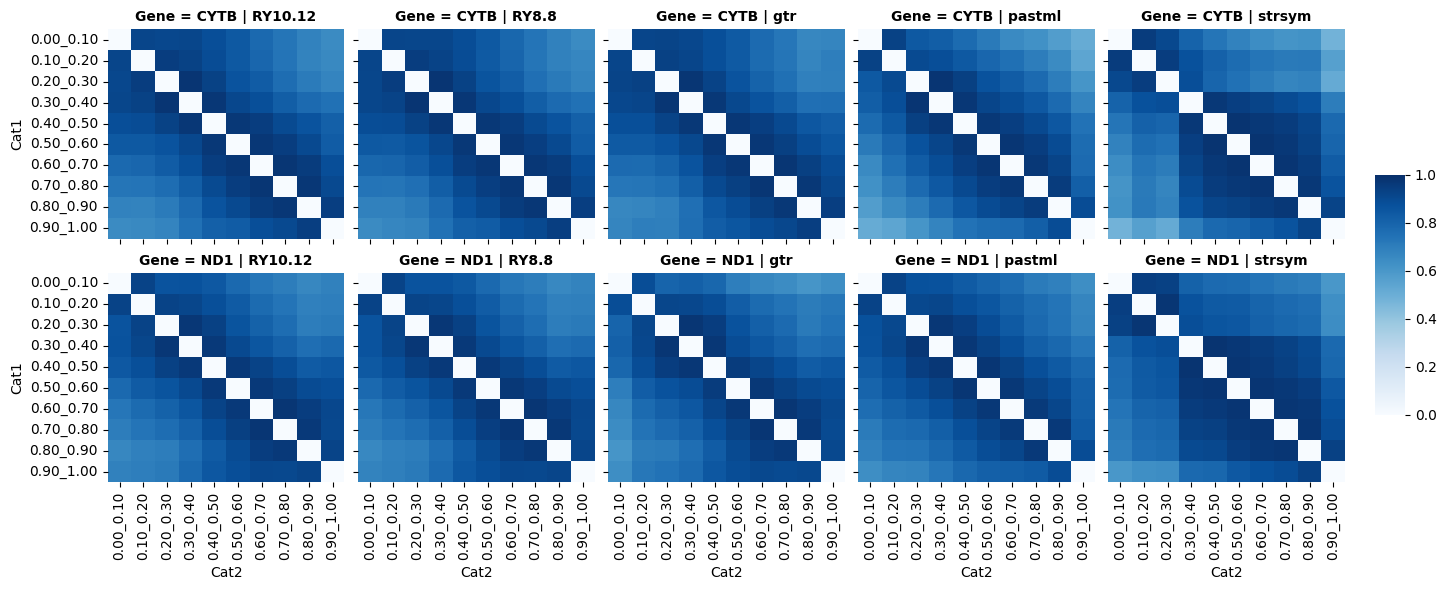

In [151]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Cat1", columns='Cat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1, )  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()

### Merged spectrum for full tree
Bad method

In [327]:
def assign_cat(p: float, interval=0.1):
    left = p // interval / 10
    right = left + interval
    return f"{left:.1f}_{right:.1f}"

In [328]:
mut_nd1["Cat"] = mut_nd1.ProbaFull.apply(assign_cat)
mut_cytb["Cat"] = mut_nd1.ProbaFull.apply(assign_cat)

In [326]:
freqs_mean = pd.concat([
    freqs_nd1[(freqs_nd1.Label == lbl) & (~freqs_nd1.Aproach.str.contains("simple"))].drop("Label", axis=1)\
              .assign(Gene="ND1").set_index(["Gene", "Aproach", "Node"]).mean(level=[0,1]),
    freqs_cytb[(freqs_cytb.Label == lbl) & (~freqs_cytb.Aproach.str.contains("simple"))].drop("Label", axis=1)\
               .assign(Gene="CYTB").set_index(["Gene", "Aproach", "Node"]).mean(level=[0,1]),
])[possible_sbs192]
freqs_mean

A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T    C[A>C]A    C[A>C]C  \
Gene Aproach                                                                  
ND1  strsym_proba      0.0      0.0      0.0      0.0  13.280685  10.119089   
     unrest_proba      0.0      0.0      0.0      0.0  11.527154   8.490058   
     proba_v2          0.0      0.0      0.0      0.0  12.719027   9.485722   
     pastml_v2         0.0      0.0      0.0      0.0  13.533498   9.752068   
CYTB strsym_proba      0.0      0.0      0.0      0.0  11.210285   6.858742   
     unrest_proba      0.0      0.0      0.0      0.0   9.922981   5.907197   
     proba_v2          0.0      0.0      0.0      0.0  10.863875   6.481020   
     pastml_v2         0.0      0.0      0.0      0.0  11.541223   6.874748   

                     C[A>C]G    C[A>C]T   G[A>C]A   G[A>C]C  ...   C[T>G]G  \
Gene Aproach                                                 ...             
ND1  strsym_proba   9.429810  10.230880  1.670049  1.997323  ...  1.446725   
     unrest_proba   8.821317   9.384316  1.517787  1.685508  ...  1.952499   
     proba_v2       9.452098  10.438284  1.569669  1.949811  ...  2.258378   
     pastml_v2      9.524027  11.175736  1.681468  1.887395  ...  2.282641   
CYTB strsym_proba  14.945701  13.770204  3.134061  3.373130  ...  1.752265   
     unrest_proba  13.651434  12.399337  2.717384  2.877056  ...  2.400105   
     proba_v2      14.638159  13.500678  2.963953  3.233310  ...  2.653754   
     pastml_v2     14.986118  14.199733  3.080081  3.166723  ...  2.707250   

                    C[T>G]T   G[T>G]A   G[T>G]C   G[T>G]G   G[T>G]T   T[T>G]A  \
Gene Aproach                                                                    
ND1  strsym_proba  1.508318  0.198409  0.288594  0.210158  0.270928  1.470090   
     unrest_proba  2.020472  0.257976  0.420276  0.248933  0.389531  1.963185   
     proba_v2      2.481739  0.315526  0.619990  0.284345  0.552110  2.217662   
     pastml_v2     2.607771  0.327029  0.621658  0.305552  0.560988  2.226176   
CYTB strsym_proba  1.660712  0.322019  0.263601  0.592229  0.452321  1.971328   
     unrest_proba  2.433802  0.470729  0.421121  0.728345  0.652592  2.831979   
     proba_v2      2.942959  0.570050  0.673063  0.817318  0.973605  3.148485   
     pastml_v2     3.070719  0.584662  0.667607  0.838789  0.917376  3.128412   

                    T[T>G]C   T[T>G]G   T[T>G]T  
Gene Aproach                                     
ND1  strsym_proba  1.329108  0.951039  0.943379  
     unrest_proba  1.794892  1.277997  1.225744  
     proba_v2      2.210254  1.359756  1.480085  
     pastml_v2     2.087561  1.290527  1.501248  
CYTB strsym_proba  2.003533  0.953465  0.785592  
     unrest_proba  3.062536  1.412646  1.147987  
     proba_v2      3.705543  1.549101  1.402232  
     pastml_v2     3.621609  1.404500  1.414438  

[8 rows x 192 columns]

In [332]:
nmuts_tree = pd.concat([
    mut_nd1[(mut_nd1.Label >= 1) & (mut_nd1.RefNode != "ROOT") & (~mut_nd1.Aproach.str.contains("simple"))]\
        .assign(Gene="ND1").groupby(["Gene", "Aproach", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0.),
    mut_cytb[(mut_cytb.Label >= 1) & (mut_cytb.RefNode != "ROOT") & (~mut_cytb.Aproach.str.contains("simple"))]\
        .assign(Gene="CYTB").groupby(["Gene", "Aproach", "Cat", "Mut"]).ProbaFull.sum().unstack().fillna(0.)
])
for sbs in set(possible_sbs192).difference(nmuts_tree.columns):
    nmuts_tree[sbs] = 0.
nmuts_tree = nmuts_tree[possible_sbs192]

In [336]:
freqs_mean["Cat"] = freqs_mean["A[A>C]A"].apply(lambda x: nmuts_tree.index.levels[2].values)
freqs_mean = freqs_mean.explode("Cat").set_index("Cat", append=True)

In [338]:
idx = nmuts_tree.index.intersection(freqs_mean.index)
nmuts_tree = nmuts_tree.loc[idx]
freqs_mean = freqs_mean.loc[idx]

assert (freqs_mean.columns == nmuts_tree.columns).all()
assert (freqs_mean.index == nmuts_tree.index).all()

ava_spectras = (nmuts_tree / freqs_mean).fillna(0.)
ava_spectras = (ava_spectras.T / ava_spectras.T.sum(axis=0)).T

### Calculate similarities

In [339]:
sim_df_mean_raw = pd.DataFrame(spatial.distance.squareform(1 - spatial.distance.pdist(ava_spectras, "cosine")), index=ava_spectras.index, columns=ava_spectras.index)

In [340]:
print(sim_df_mean_raw.index.levels)

[['CYTB', 'ND1'], ['pastml_v2', 'proba_v2', 'strsym_proba', 'unrest_proba'], ['0.0_0.1', '0.1_0.2', '0.2_0.3', '0.3_0.4', '0.4_0.5', '0.5_0.6', '0.6_0.7', '0.7_0.8', '0.8_0.9', '0.9_1.0']]


In [341]:
data = []
for g in sim_df_mean_raw.index.levels[0]:
    for appr in sim_df_mean_raw.index.levels[1]:
        a = sim_df_mean_raw.loc[(g, appr), (g, appr)]
        a.index.rename("Cat1", inplace=True)
        a.columns.rename("Cat2", inplace=True)
        a = a.stack().rename("Sim").reset_index()
        a["Gene"] = g
        a["Approach"] = appr
        data.append(a)

sim_df_mean = pd.concat(data)
sim_df_mean.head()

,Cat1,Cat2,Sim,Gene,Approach
0,0.0_0.1,0.0_0.1,0.000000,CYTB,pastml_v2
1,0.0_0.1,0.1_0.2,0.997718,CYTB,pastml_v2
2,0.0_0.1,0.2_0.3,0.997208,CYTB,pastml_v2
3,0.0_0.1,0.3_0.4,0.990547,CYTB,pastml_v2
4,0.0_0.1,0.4_0.5,0.978879,CYTB,pastml_v2


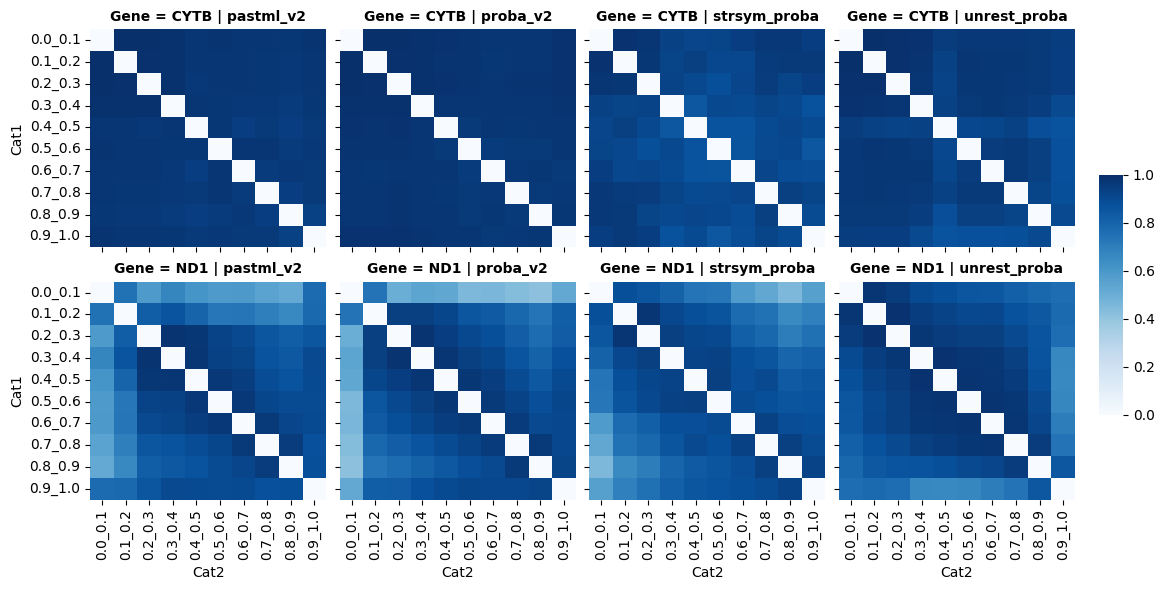

In [342]:
def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Cat1", columns='Cat2', values='Sim')
    sns.heatmap(data, cmap='Blues', **kws)  # <-- Pass kwargs to heatmap

with sns.plotting_context(font_scale=5.5):
    g = sns.FacetGrid(sim_df_mean, row="Gene", col="Approach", size=3, aspect=1)

cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1, )  # <-- Specify the colorbar axes and limits

g.set_titles(col_template="{col_name}", fontweight='bold', size=10)
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot
plt.show()